# Support Vector Machines (SVM): Theory and Implementation

## 1. Introduction

Support Vector Machines (SVMs) are powerful supervised learning algorithms used for classification and regression tasks. Introduced by Vapnik and colleagues in the 1990s, SVMs have become one of the most robust and well-studied classification methods in machine learning.

The fundamental idea behind SVMs is to find the optimal hyperplane that maximally separates data points belonging to different classes.

## 2. Mathematical Foundation

### 2.1 Linear SVM for Separable Data

Consider a binary classification problem with training data $\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \{-1, +1\}$.

A hyperplane in $\mathbb{R}^d$ can be written as:

$$\mathbf{w}^T \mathbf{x} + b = 0$$

where $\mathbf{w} \in \mathbb{R}^d$ is the normal vector to the hyperplane and $b \in \mathbb{R}$ is the bias term.

### 2.2 The Margin

The **margin** is defined as the perpendicular distance between the hyperplane and the nearest data points from either class. For a correctly classified point, we require:

$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1$$

The geometric margin (distance from a point to the hyperplane) is:

$$\gamma_i = \frac{y_i(\mathbf{w}^T \mathbf{x}_i + b)}{\|\mathbf{w}\|}$$

The total margin width is $\frac{2}{\|\mathbf{w}\|}$.

### 2.3 Optimization Problem

To maximize the margin, we minimize $\|\mathbf{w}\|^2$. The **primal optimization problem** is:

$$\min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2$$

subject to:

$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \quad i = 1, \ldots, n$$

### 2.4 Lagrangian Dual Formulation

Introducing Lagrange multipliers $\alpha_i \geq 0$, the Lagrangian is:

$$\mathcal{L}(\mathbf{w}, b, \boldsymbol{\alpha}) = \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{i=1}^{n} \alpha_i [y_i(\mathbf{w}^T \mathbf{x}_i + b) - 1]$$

Setting $\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = 0$ and $\frac{\partial \mathcal{L}}{\partial b} = 0$ yields:

$$\mathbf{w} = \sum_{i=1}^{n} \alpha_i y_i \mathbf{x}_i$$

$$\sum_{i=1}^{n} \alpha_i y_i = 0$$

The **dual problem** becomes:

$$\max_{\boldsymbol{\alpha}} \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j$$

subject to:

$$\alpha_i \geq 0, \quad \sum_{i=1}^{n} \alpha_i y_i = 0$$

### 2.5 Support Vectors

Points with $\alpha_i > 0$ are called **support vectors**. These are the critical points that lie on the margin boundaries and fully determine the decision boundary.

### 2.6 Soft Margin SVM

For non-separable data, we introduce slack variables $\xi_i \geq 0$:

$$\min_{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i$$

subject to:

$$y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0$$

The parameter $C > 0$ controls the trade-off between margin maximization and classification error.

### 2.7 The Kernel Trick

For non-linearly separable data, we map inputs to a higher-dimensional feature space via $\phi: \mathbb{R}^d \rightarrow \mathcal{H}$. The **kernel function** computes inner products in this space:

$$K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T \phi(\mathbf{x}_j)$$

Common kernels include:

- **Linear:** $K(\mathbf{x}, \mathbf{z}) = \mathbf{x}^T \mathbf{z}$
- **Polynomial:** $K(\mathbf{x}, \mathbf{z}) = (\mathbf{x}^T \mathbf{z} + c)^d$
- **RBF (Gaussian):** $K(\mathbf{x}, \mathbf{z}) = \exp\left(-\gamma \|\mathbf{x} - \mathbf{z}\|^2\right)$

## 3. Implementation

We will implement a simple SVM from scratch using quadratic programming, and visualize the decision boundary on synthetic 2D data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)

### 3.1 Generate Synthetic Data

We create two linearly separable clusters in 2D space.

In [2]:
def generate_data(n_samples=100, separation=2.0):
    """
    Generate linearly separable 2D data.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples per class
    separation : float
        Distance between class centers
    
    Returns:
    --------
    X : ndarray of shape (2*n_samples, 2)
        Feature matrix
    y : ndarray of shape (2*n_samples,)
        Labels in {-1, +1}
    """
    # Class +1: centered at (separation/2, separation/2)
    X_pos = np.random.randn(n_samples, 2) * 0.8 + np.array([separation/2, separation/2])
    
    # Class -1: centered at (-separation/2, -separation/2)
    X_neg = np.random.randn(n_samples, 2) * 0.8 + np.array([-separation/2, -separation/2])
    
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(n_samples), -np.ones(n_samples)])
    
    return X, y

# Generate data
X, y = generate_data(n_samples=50, separation=3.0)

print(f"Dataset shape: X = {X.shape}, y = {y.shape}")
print(f"Class distribution: +1 = {np.sum(y == 1)}, -1 = {np.sum(y == -1)}")

Dataset shape: X = (100, 2), y = (100,)
Class distribution: +1 = 50, -1 = 50


### 3.2 SVM Implementation

We solve the dual optimization problem using scipy's minimize function with the SLSQP method.

In [3]:
class LinearSVM:
    """
    Linear Support Vector Machine classifier.
    
    Implements the hard-margin SVM by solving the dual optimization problem.
    """
    
    def __init__(self, C=1.0):
        """
        Parameters:
        -----------
        C : float
            Regularization parameter (for soft margin)
        """
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.alphas = None
        
    def fit(self, X, y):
        """
        Fit the SVM model.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Labels in {-1, +1}
        """
        n_samples, n_features = X.shape
        
        # Compute the Gram matrix
        K = np.dot(X, X.T)
        
        # Objective function: -sum(alpha) + 0.5 * alpha^T Q alpha
        # where Q_ij = y_i * y_j * K_ij
        Q = np.outer(y, y) * K
        
        def objective(alpha):
            return 0.5 * np.dot(alpha, np.dot(Q, alpha)) - np.sum(alpha)
        
        def gradient(alpha):
            return np.dot(Q, alpha) - np.ones(n_samples)
        
        # Constraints: sum(alpha_i * y_i) = 0
        constraints = {'type': 'eq', 'fun': lambda a: np.dot(a, y), 'jac': lambda a: y}
        
        # Bounds: 0 <= alpha_i <= C
        bounds = [(0, self.C) for _ in range(n_samples)]
        
        # Initial guess
        alpha0 = np.zeros(n_samples)
        
        # Solve the optimization problem
        result = minimize(
            objective, 
            alpha0, 
            method='SLSQP', 
            jac=gradient,
            bounds=bounds, 
            constraints=constraints,
            options={'ftol': 1e-10, 'maxiter': 1000}
        )
        
        self.alphas = result.x
        
        # Support vectors have alpha > threshold
        sv_threshold = 1e-5
        sv_mask = self.alphas > sv_threshold
        
        self.support_vectors = X[sv_mask]
        self.support_vector_labels = y[sv_mask]
        self.support_alphas = self.alphas[sv_mask]
        
        # Compute weight vector: w = sum(alpha_i * y_i * x_i)
        self.w = np.sum((self.alphas * y)[:, np.newaxis] * X, axis=0)
        
        # Compute bias: b = y_s - w^T x_s for any support vector
        # Average over all support vectors for numerical stability
        self.b = np.mean(
            self.support_vector_labels - np.dot(self.support_vectors, self.w)
        )
        
        return self
    
    def decision_function(self, X):
        """Compute the signed distance to the hyperplane."""
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        """Predict class labels."""
        return np.sign(self.decision_function(X))

### 3.3 Train the SVM

In [4]:
# Create and train the SVM
svm = LinearSVM(C=100.0)  # Large C for near-hard margin
svm.fit(X, y)

print(f"Weight vector w = {svm.w}")
print(f"Bias term b = {svm.b:.4f}")
print(f"Number of support vectors: {len(svm.support_vectors)}")

# Compute training accuracy
predictions = svm.predict(X)
accuracy = np.mean(predictions == y)
print(f"Training accuracy: {accuracy * 100:.2f}%")

Weight vector w = [1.1175888  0.89510655]
Bias term b = -0.0742
Number of support vectors: 3
Training accuracy: 100.00%


### 3.4 Visualization

We visualize the decision boundary, margin boundaries, and support vectors.

Plot saved to 'plot.png'


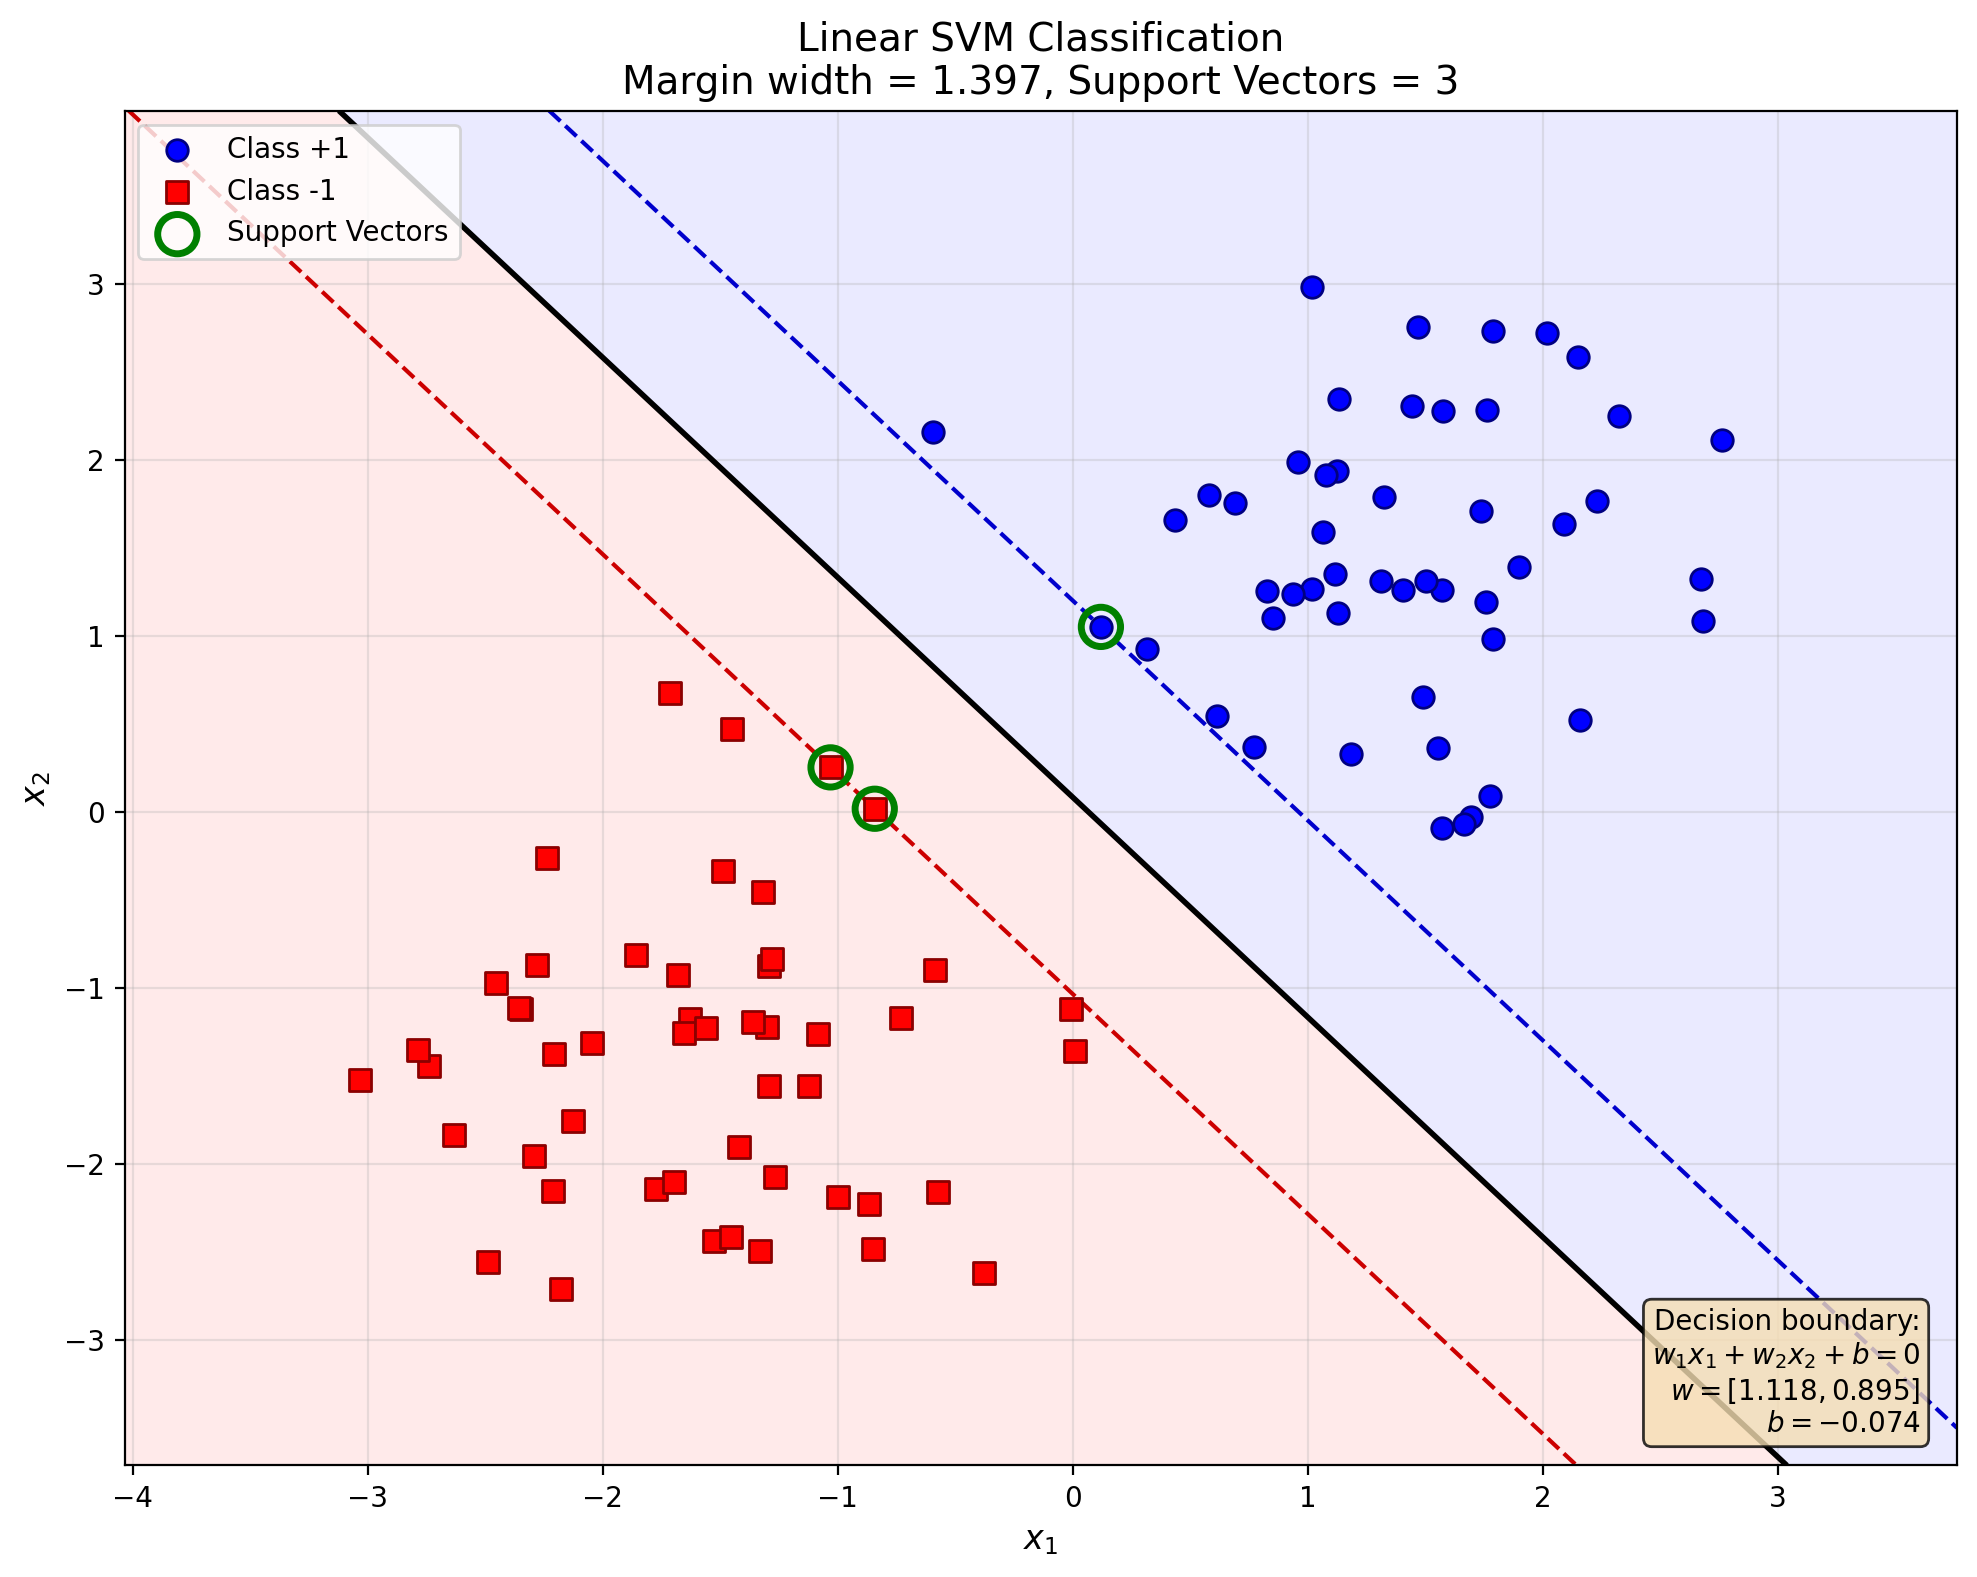

In [5]:
def plot_svm_decision_boundary(svm, X, y, title="SVM Decision Boundary"):
    """
    Plot the SVM decision boundary with margins and support vectors.
    
    Parameters:
    -----------
    svm : LinearSVM
        Trained SVM model
    X : ndarray
        Feature matrix
    y : ndarray
        Labels
    title : str
        Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create mesh grid for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Compute decision function on mesh
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions with soft colors
    cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], 
                colors=['#FFCCCC', '#CCCCFF'], alpha=0.4)
    
    # Plot decision boundary and margins
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], 
               colors=['#CC0000', 'black', '#0000CC'],
               linestyles=['--', '-', '--'], linewidths=[1.5, 2, 1.5])
    
    # Plot data points
    scatter_pos = ax.scatter(X[y == 1, 0], X[y == 1, 1], 
                             c='blue', marker='o', s=60, 
                             edgecolors='navy', linewidths=1,
                             label='Class +1', zorder=3)
    scatter_neg = ax.scatter(X[y == -1, 0], X[y == -1, 1], 
                             c='red', marker='s', s=60, 
                             edgecolors='darkred', linewidths=1,
                             label='Class -1', zorder=3)
    
    # Highlight support vectors
    ax.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1],
               s=200, facecolors='none', edgecolors='green', 
               linewidths=2.5, label='Support Vectors', zorder=4)
    
    # Add annotations
    margin = 2 / np.linalg.norm(svm.w)
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_title(f'{title}\nMargin width = {margin:.3f}, '
                 f'Support Vectors = {len(svm.support_vectors)}', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Add text box with equation
    textstr = f'Decision boundary:\n$w_1 x_1 + w_2 x_2 + b = 0$\n'
    textstr += f'$w = [{svm.w[0]:.3f}, {svm.w[1]:.3f}]$\n$b = {svm.b:.3f}$'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    return fig, ax

# Create the visualization
fig, ax = plot_svm_decision_boundary(svm, X, y, 
                                      title="Linear SVM Classification")

# Save the plot
plt.savefig('support_vector_machine_svm_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
print("Plot saved to 'plot.png'")
plt.show()

## 4. Analysis of Results

### 4.1 Understanding the Decision Boundary

The solid black line represents the optimal separating hyperplane:

$$w_1 x_1 + w_2 x_2 + b = 0$$

The dashed lines represent the margin boundaries where $\mathbf{w}^T \mathbf{x} + b = \pm 1$.

### 4.2 Support Vectors

The circled points are support vectors - they are the only points that influence the position of the decision boundary. All other points could be moved or removed without changing the classifier, as long as they remain on the correct side of the margin.

### 4.3 Margin Interpretation

The margin width is $\frac{2}{\|\mathbf{w}\|}$. A larger margin generally indicates better generalization capability, according to statistical learning theory.

In [6]:
# Additional analysis: examine support vectors
print("Support Vector Analysis")
print("=" * 50)
print(f"\nNumber of support vectors: {len(svm.support_vectors)}")
print(f"Percentage of training data: {100 * len(svm.support_vectors) / len(X):.1f}%")
print(f"\nMargin width: {2 / np.linalg.norm(svm.w):.4f}")
print(f"||w||: {np.linalg.norm(svm.w):.4f}")

# Verify KKT conditions for support vectors
print("\nVerifying KKT conditions for support vectors:")
for i, (sv, label, alpha) in enumerate(zip(svm.support_vectors, 
                                            svm.support_vector_labels,
                                            svm.support_alphas)):
    margin_distance = label * (np.dot(svm.w, sv) + svm.b)
    print(f"  SV {i+1}: y*(w·x + b) = {margin_distance:.6f}, alpha = {alpha:.6f}")

Support Vector Analysis

Number of support vectors: 3
Percentage of training data: 3.0%

Margin width: 1.3968
||w||: 1.4319

Verifying KKT conditions for support vectors:
  SV 1: y*(w·x + b) = 0.999997, alpha = 1.025112
  SV 2: y*(w·x + b) = 0.999999, alpha = 0.696221
  SV 3: y*(w·x + b) = 0.999998, alpha = 0.328891


## 5. Conclusion

This notebook demonstrated the mathematical foundations and practical implementation of Support Vector Machines:

1. **Theoretical Framework**: We derived the primal and dual optimization problems, showing how SVMs maximize the margin between classes.

2. **Implementation**: A working linear SVM was implemented from scratch using quadratic programming via scipy's SLSQP optimizer.

3. **Visualization**: The decision boundary, margins, and support vectors were visualized, demonstrating how only a small subset of training points (support vectors) determine the classifier.

Key takeaways:
- SVMs find the maximum-margin hyperplane, providing good generalization
- The solution depends only on support vectors (sparse representation)
- The kernel trick enables non-linear classification in the original feature space
- The regularization parameter $C$ controls the bias-variance trade-off

### References

1. Vapnik, V. N. (1995). *The Nature of Statistical Learning Theory*. Springer.
2. Cortes, C., & Vapnik, V. (1995). Support-vector networks. *Machine Learning*, 20(3), 273-297.
3. Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.